In [15]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.ticker import MaxNLocator

import numpy as np
import torch
import torch.nn.functional as F

from dataloaders.nascar import NascarDataLoader
from dataloaders.bouncing_data import BouncingBallDataLoader, MissingBallDataset, SquareBallDataset
from torch.utils.data import DataLoader
from models.KalmanVAE import KalmanVAE
from models.ExtendedKalmanVAE import ExtendedKalmanVAE
from models.VRNN import VRNN
from tqdm import tqdm
from utils.losses import mse_through_time

torch.autograd.set_detect_anomaly(True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
B=1
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_square_black_white_small/test', images=True)
train_loader = DataLoader(dl, batch_size=B, shuffle=True, num_workers=4)
im = next(iter(train_loader)).cuda().float()
print(im.size())

torch.Size([1, 50, 1, 32, 32])


In [53]:
kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=256, 
                latent_dim=24, num_modes=3, beta=0.3, 
                alpha='rnn', mode='kglow').float().cuda()
print(kvae)
checkpoint = torch.load('/data2/users/cb221/stored_models_GLOW/KVAE_kglow_rnn_latest.pth.tar')
kvae.load_state_dict(checkpoint['kvae'])

KalmanVAE(
  (flow_model): Glow(
    (blocks): ModuleList(
      (0): Block(
        (flows): ModuleList(
          (0): Flow(
            (actnorm): ActNorm()
            (invconv): InvConv2dLU()
            (coupling): AffineCoupling(
              (net): Sequential(
                (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU(inplace=True)
                (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
                (3): ReLU(inplace=True)
                (4): ZeroConv2d(
                  (conv): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))
                )
              )
            )
          )
          (1): Flow(
            (actnorm): ActNorm()
            (invconv): InvConv2dLU()
            (coupling): AffineCoupling(
              (net): Sequential(
                (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU(inplace=True)
                (2): Conv2d(16, 16,

<All keys matched successfully>

In [5]:
kvae.split_sizes

In [54]:
with torch.no_grad():
    kvae.split_sizes = None
    input = (sample[:,:20] > 0.5).float().cuda()
    n_bins = 32
    var = input - 0.5
    x_hat, a_mu, _, losses = kvae(var + torch.rand_like(var)/n_bins)
    x_hat = (x_hat + 0.5)
    x_hat[x_hat > 0.5] = 1
    x_hat[x_hat <= 0.5] = 0
    for i in range(4):
        kvae.split_sizes[i] = list(kvae.split_sizes[i])
        kvae.split_sizes[i][0] = B*20
    pred_pos, obs_seq, _ = kvae.predict_sequence(var + torch.rand_like(var)/n_bins, seq_len=20)
    target = sample[:,20:40].to(pred_pos.device)
    pred_pos = (pred_pos + 0.5)
    pred_mse = F.mse_loss(pred_pos, target, reduction='sum')

/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [55]:
count_pred = 0
count_autoencode = 0
mask = [True]*B
for i in range(B):
    if torch.any(pred_pos[i].isnan()):
        count_pred +=1
        print(i)
        mask[i] = False
    if torch.any(x_hat[i].isnan()):
        count_autoencode +=1
pred_pos_masked = pred_pos[mask,:,:,:]
print(count_autoencode, count_pred, pred_pos_masked.size())

50
59
100
0 3 torch.Size([125, 20, 1, 16, 16])


In [11]:
torch.unique(torch.where(pred_pos[106].isnan())[0])

IndexError: index 106 is out of bounds for dimension 0 with size 16

In [7]:
for i in range(20):
    print(i,obs_seq[106,i].max(), obs_seq[106,i].min())

NameError: name 'obs_seq' is not defined

In [29]:
obs_seq[106,8]

tensor([-1.3781e-02, -2.9967e-03, -3.1015e-03, -1.2032e-02, -1.3269e-02,
        -1.2944e-04, -9.1729e-03, -1.4926e-02, -9.0722e-03, -3.5717e-03,
        -2.0252e-02, -8.2590e-03, -4.6704e-03, -1.3552e-02,  8.2677e-04,
        -1.5838e-02, -1.4445e-02, -1.0812e-02, -7.4663e-03, -7.6341e-03,
        -8.8543e-03,  4.0915e-03, -9.2350e-03, -2.9003e-02, -8.8940e-03,
        -1.2011e-02, -8.9062e-03, -1.1827e-02, -3.6394e-03, -1.5327e-02,
         2.2785e-03, -1.0653e-02,  1.6149e-03, -2.7032e-03, -4.1859e-03,
        -1.0415e-02, -1.2869e-02, -6.2390e-03,  9.3674e-04, -1.2333e-02,
        -1.4500e-02, -8.5887e-03, -1.5980e-02, -1.0359e-02, -1.2161e-03,
        -5.2386e-03, -1.6314e-03, -5.6252e-03, -1.5560e-02, -8.8540e-03,
        -3.9863e-03, -8.1177e-03,  1.2348e-03, -1.0322e-03, -7.0421e-03,
        -1.6007e-02, -1.5311e-03, -2.4873e-02,  1.5572e-03, -1.4898e-02,
        -1.0202e-03, -6.0529e-03, -1.3679e-02, -2.0096e-02, -1.5342e-02,
        -1.5698e-02, -2.0368e-02, -2.0361e-02, -1.6

In [56]:
decode_in = []
idx = 256
offset = 0
for i in range(4):
    kvae.split_sizes[i] = list(kvae.split_sizes[i])
    kvae.split_sizes[i][0] = 1*1
for i in range(4):
    if i!=3:
        idx //= 2
    decode_in.append(obs_seq[106,8,offset:offset+idx].reshape(kvae.split_sizes[i]))
    offset += idx
image_seq = kvae.flow_model.reverse(decode_in,True).reshape(1,16,16)

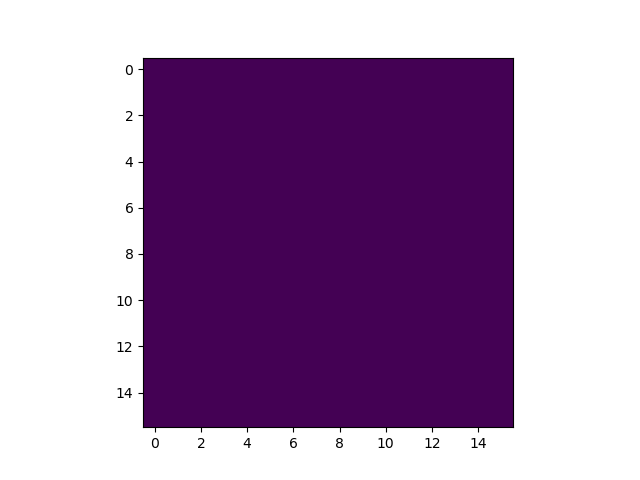

In [126]:
plt.imshow(pred_pos[19,17,0].isnan().float().cpu().detach().numpy())
plt.show()

In [128]:
def get_frames(frames_np):
    fig, ax = plt.subplots()
    ims = []
    for i in range(20):
        im_ax = ax.imshow(frames_np[i], animated=True)
        ims.append([im_ax])
    return fig, ims

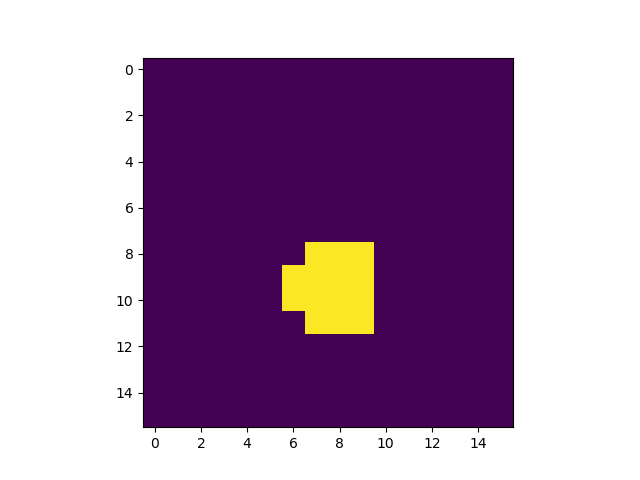

In [7]:
fig_pred, ims_pred = get_frames(x_hat[0].cpu().detach().numpy().transpose((0,3,2,1)))
ani_sample = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()

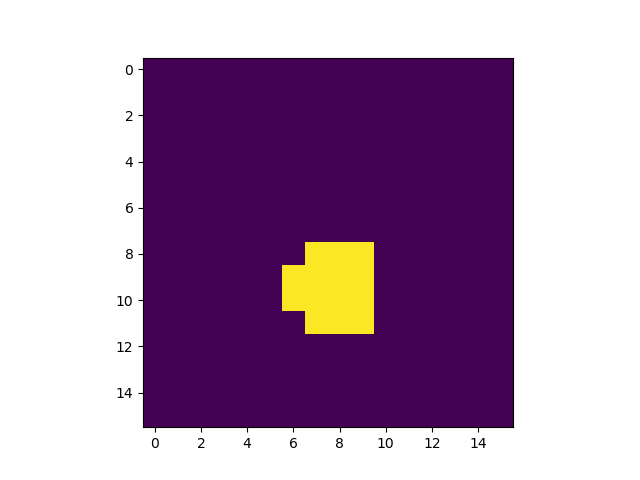

In [8]:
fig_pred, ims_pred = get_frames(sample[0,:20].cpu().detach().numpy().transpose((0,3,2,1)))
ani_sample = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()

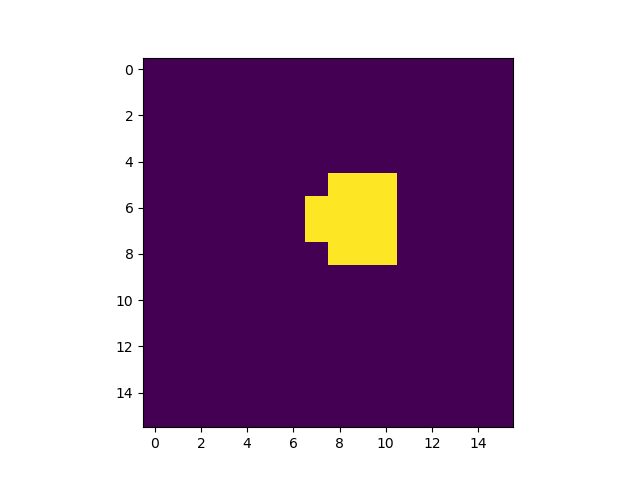

In [131]:
fig_pred, ims_pred = get_frames((pred_pos[0,:20] > 0.5).float().cpu().detach().numpy().transpose((0,3,2,1)))
ani_sample = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()

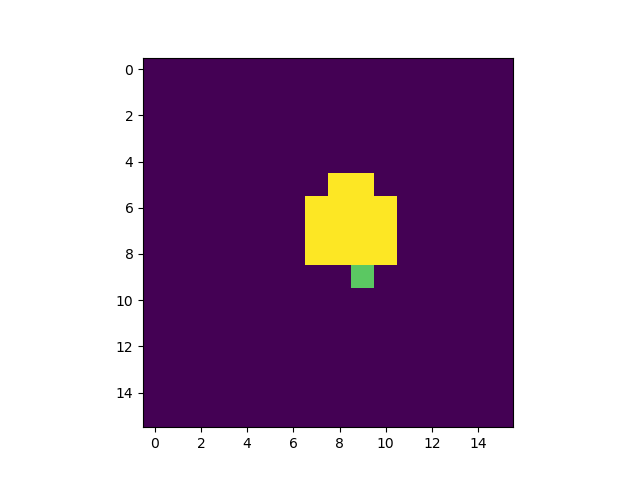

In [129]:
fig_pred, ims_pred = get_frames(sample[0,20:40].cpu().detach().numpy().transpose((0,3,2,1)))
ani_sample = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
plt.show()

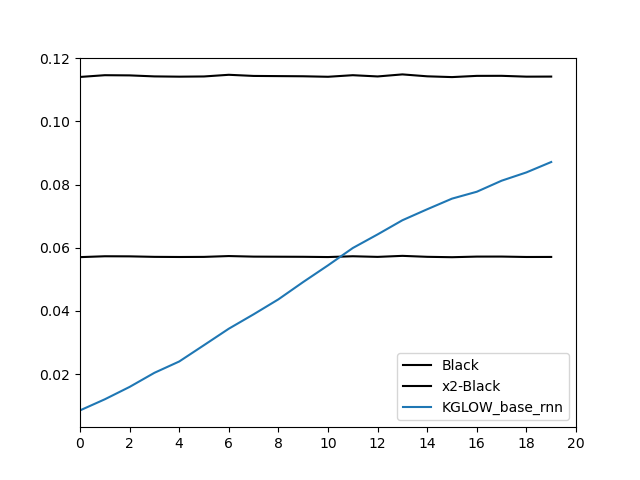

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [5]:
#plt.figure()

100%|██████████| 100/100 [00:15<00:00,  6.42it/s]
/homes/cb221/codebase/bouncing-ball/glow_pytorch/model.py:102: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  w_s = torch.from_numpy(w_s)
  0%|          | 0/100 [00:00<?, ?it/s]/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/100 [00:00<?, ?it/s]/data2/packages/anacond

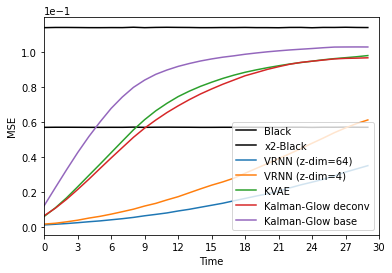

In [5]:
from models.VRNN import VRNN
from models.KalmanVAE import KalmanVAE
plt.figure()
ax = plt.gca()
B=10
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_square_black_white_small/test', images=True)
train_loader = torch.utils.data.DataLoader(dl, batch_size=B, shuffle=True)
mse_t_t_list = np.empty((30,0))
for sample in tqdm(train_loader):
    mse_t_t = mse_through_time(torch.zeros_like(sample[:,20:50]), sample[:,20:50], reduce=False).cpu().detach().numpy()
    mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
mse_t_t = mse_t_t_list.mean(axis=1)
plt.plot(range(30),mse_t_t, label='Black',c='k')
plt.plot(range(30),2*mse_t_t, label='x2-Black',c='k')
plt.xlim((0,30))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
with torch.no_grad():
    # VRNN 64 latents
    vrnn = VRNN(1, 2, 256, 64, num_rec_layers=3, input_type='visual').float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models_GLOW/VRNN_bouncing_ball_black_white_latest.pth.tar')
    vrnn.load_state_dict(checkpoint['vrnn'])
    T=30
    mse_t_t_list = np.empty((30,0))
    for im in tqdm(train_loader):
        pred_ = vrnn.predict_sequence((im[:,:20] > 0.5).float().cuda(),seq_len=T)
        target_ = im[:,20:20+T].float().to(pred_.device)
        mse_t_t = mse_through_time(pred_, target_, reduce=False).cpu().detach().numpy()
        mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
    mse_t_t = mse_t_t_list.mean(axis=1)
    plt.plot(range(T),mse_t_t, label='VRNN (z-dim=64)')
    # VRNN 4 latents
    vrnn = VRNN(1, 2, 256, 4, num_rec_layers=3, input_type='visual').float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models_GLOW/VRNN_bouncing_ball_black_white_4_latents_latest.pth.tar')
    vrnn.load_state_dict(checkpoint['vrnn'])
    T=30
    mse_t_t_list = np.empty((30,0))
    for im in tqdm(train_loader):
        pred_ = vrnn.predict_sequence((im[:,:20] > 0.5).float().cuda(),seq_len=T)
        target_ = im[:,20:20+T].float().to(pred_.device)
        mse_t_t = mse_through_time(pred_, target_, reduce=False).cpu().detach().numpy()
        mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
    mse_t_t = mse_t_t_list.mean(axis=1)
    plt.plot(range(T),mse_t_t, label='VRNN (z-dim=4)')

    kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=2, 
                latent_dim=4, num_modes=3, beta=0.3, 
                alpha='rnn', mode='base').float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models_KVAE/KVAE_rnn_2_latest.pth.tar')
    kvae.load_state_dict(checkpoint['kvae'])
    mse_t_t_list = np.empty((30,0))
    for im in tqdm(train_loader):
        pred_pos, obs_seq, _ = kvae.predict_sequence((im[:,:20] > 0.5).float().cuda(),seq_len=T)
        target = im[:,20:50].to(pred_pos.device)
        mse_t_t = mse_through_time(pred_pos, target, reduce=False).cpu().detach().numpy()
        mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
    mse_t_t = mse_t_t_list.mean(axis=1)
    plt.plot(range(30),mse_t_t, label='KVAE')

    kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=1024, 
                latent_dim=4, num_modes=3, beta=0.3, 
                alpha='rnn', mode='greparam').float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models_GLOW/KVAE_glow_32x32_to_1x1x4_latest.pth.tar')
    kvae.load_state_dict(checkpoint['kvae'])
    mse_t_t_list = np.empty((30,0))
    first = True
    for sample in tqdm(train_loader):
        input = (sample[:,:20] > 0.5).float().cuda()
        n_bins = 32
        var = input - 0.5
        if first:
            kvae(var + torch.rand_like(var)/n_bins)
            for i in range(4):
                kvae.split_sizes[i] = list(kvae.split_sizes[i])
                kvae.split_sizes[i][0] = B*30
            first = False
        pred_pos, obs_seq, _ = kvae.predict_sequence(var + torch.rand_like(var)/n_bins, seq_len=30)
        target = sample[:,20:50].to(pred_pos.device)
        pred_pos = (pred_pos + 0.5)
        pred_mse = F.mse_loss(pred_pos, target, reduction='sum')

        count_pred = 0
        count_autoencode = 0
        mask = [True]*B
        for i in range(B):
            if torch.any(pred_pos[i].isnan()):
                count_pred +=1
                print(i)
                mask[i] = False
        pred_pos_masked = pred_pos[mask,:,:,:]
        mse_t_t = mse_through_time(pred_pos_masked[:,:30], target[mask,:], reduce=False).cpu().detach().numpy()
        mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
    mse_t_t = mse_t_t_list.mean(axis=1)
    plt.plot(range(30),mse_t_t, label='Kalman-Glow deconv')

    kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=1024, 
                latent_dim=4, num_modes=3, beta=0.3, 
                alpha='rnn', mode='kglow').float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models_KVAE/KGLOW_rnn_32x32_full_mat_latest.pth.tar')
    kvae.load_state_dict(checkpoint['kvae'])
    mse_t_t_list = np.empty((30,0))
    first = True
    for sample in tqdm(train_loader):
        input = (sample[:,:20] > 0.5).float().cuda()
        n_bins = 32
        var = input - 0.5
        if first:
            kvae(var + torch.rand_like(var)/n_bins)
            for i in range(4):
                kvae.split_sizes[i] = list(kvae.split_sizes[i])
                kvae.split_sizes[i][0] = B*30
            first = False
        pred_pos, obs_seq, _ = kvae.predict_sequence(var + torch.rand_like(var)/n_bins, seq_len=30)
        target = sample[:,20:50].to(pred_pos.device)
        pred_pos = (pred_pos + 0.5)
        pred_mse = F.mse_loss(pred_pos, target, reduction='sum')

        count_pred = 0
        count_autoencode = 0
        mask = [True]*B
        for i in range(B):
            if torch.any(pred_pos[i].isnan()):
                count_pred +=1
                print(i)
                mask[i] = False
        pred_pos_masked = pred_pos[mask,:,:,:]
        mse_t_t = mse_through_time(pred_pos_masked[:,:30], target[mask,:], reduce=False).cpu().detach().numpy()
        mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
    mse_t_t = mse_t_t_list.mean(axis=1)
    plt.plot(range(30),mse_t_t, label='Kalman-Glow base')
    plt.xlabel('Time')
    plt.ylabel('MSE')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.legend()
    plt.savefig("mse_throught_time_convex_vrnn.pdf")

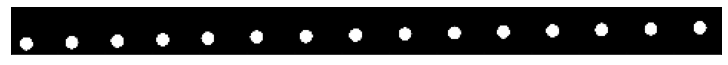

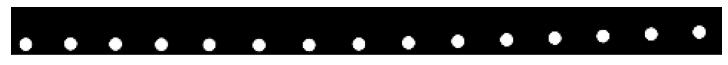

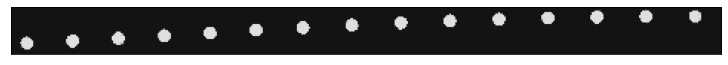

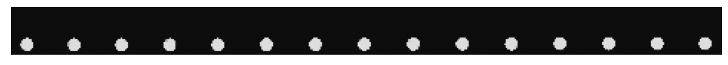

In [17]:
T=30
B=1
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_square_black_white_small/test', images=True)
train_loader = DataLoader(dl, batch_size=B, shuffle=False, num_workers=4)
#im = next(iter(train_loader)).cuda().float()
target = im[:,20:50].cuda()
plt.figure(figsize=(10,10), constrained_layout=True)
#plt.imshow(im.permute(0,1,3,4,2)[0,0,].detach().cpu().numpy())
plt.imshow(np.concatenate(target.permute(0,1,3,4,2)[0,::2].detach().cpu().numpy(), axis=1), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig('bouncing_ball_white_viz_groundtruth.png',dpi=300)


vrnn = VRNN(1, 2, 256, 64, num_rec_layers=3, input_type='visual').float().cuda()
checkpoint = torch.load('/data2/users/cb221/stored_models_GLOW/VRNN_bouncing_ball_black_white_latest.pth.tar')
vrnn.load_state_dict(checkpoint['vrnn'])
pred_ = vrnn.predict_sequence((im[:,:20] > 0.5).float().cuda(),seq_len=T)
plt.imshow(np.concatenate(pred_.permute(0,1,3,4,2)[0,::2].detach().cpu().numpy(), axis=1), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig('bouncing_ball_white_viz_VRNN_64.png',dpi=300)

# VRNN 4 latents
vrnn = VRNN(1, 2, 256, 4, num_rec_layers=3, input_type='visual').float().cuda()
checkpoint = torch.load('/data2/users/cb221/stored_models_GLOW/VRNN_bouncing_ball_black_white_4_latents_latest.pth.tar')
vrnn.load_state_dict(checkpoint['vrnn'])
pred_ = vrnn.predict_sequence((im[:,:20] > 0.5).float().cuda(),seq_len=T)
plt.imshow(np.concatenate(pred_.permute(0,1,3,4,2)[0,::2].detach().cpu().numpy(), axis=1), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig('bouncing_ball_white_viz_VRNN_4.png',dpi=300)

kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=2, 
            latent_dim=4, num_modes=3, beta=0.3, 
            alpha='rnn', mode='base').float().cuda()
checkpoint = torch.load('/data2/users/cb221/stored_models_KVAE/KVAE_rnn_latest.pth.tar')
kvae.load_state_dict(checkpoint['kvae'])
pred_pos, obs_seq, _ = kvae.predict_sequence((im[:,:20] > 0.5).float().cuda(),seq_len=T)

plt.figure(figsize=(10,10), constrained_layout=True)
#plt.imshow(im.permute(0,1,3,4,2)[0,0,].detach().cpu().numpy())
plt.imshow(np.concatenate(pred_pos.permute(0,1,3,4,2)[0,::2].detach().cpu().numpy(), axis=1), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig('bouncing_ball_white_viz_KVAE.png',dpi=300)

input = (im[:,:20] > 0.5).float().cuda()
n_bins = 32
var = input - 0.5

kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=1024, 
                latent_dim=4, num_modes=3, beta=0.3, 
                alpha='rnn', mode='greparam').float().cuda()
checkpoint = torch.load('/data2/users/cb221/stored_models_GLOW/KVAE_glow_32x32_to_1x1x4_latest.pth.tar')
kvae.load_state_dict(checkpoint['kvae'])
kvae(var + torch.rand_like(var)/n_bins)
for i in range(4):
    kvae.split_sizes[i] = list(kvae.split_sizes[i])
    kvae.split_sizes[i][0] = B*30
pred_pos, obs_seq, _ = kvae.predict_sequence(var + torch.rand_like(var)/n_bins, seq_len=30)
pred_pos = (pred_pos + 0.5)
plt.figure(figsize=(10,10), constrained_layout=True)
#plt.imshow(im.permute(0,1,3,4,2)[0,0,].detach().cpu().numpy())
plt.imshow(np.concatenate(pred_pos.permute(0,1,3,4,2)[0,::2].detach().cpu().numpy(), axis=1), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig('bouncing_ball_white_viz_KGLOW_deconv.png',dpi=300)


kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=1024, 
            latent_dim=4, num_modes=3, beta=0.3, 
            alpha='rnn', mode='kglow').float().cuda()
checkpoint = torch.load('/data2/users/cb221/stored_models_KVAE/KGLOW_rnn_32x32_full_mat_latest.pth.tar')
kvae.load_state_dict(checkpoint['kvae'])
kvae(var + torch.rand_like(var)/n_bins)
for i in range(4):
    kvae.split_sizes[i] = list(kvae.split_sizes[i])
    kvae.split_sizes[i][0] = B*30
pred_pos, obs_seq, _ = kvae.predict_sequence(var + torch.rand_like(var)/n_bins, seq_len=30)
pred_pos = (pred_pos + 0.5)
plt.figure(figsize=(10,10), constrained_layout=True)
#plt.imshow(im.permute(0,1,3,4,2)[0,0,].detach().cpu().numpy())
plt.imshow(np.concatenate(pred_pos.permute(0,1,3,4,2)[0,::2].detach().cpu().numpy(), axis=1), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig('bouncing_ball_white_viz_KGLOW_full_mat.png',dpi=300)


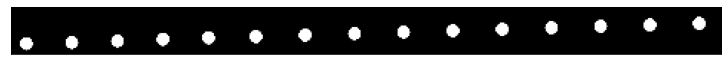

In [13]:
T=30
B=10
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_square_black_white_small/test', images=True)
train_loader = DataLoader(dl, batch_size=B, shuffle=False, num_workers=4)
#im = next(iter(train_loader)).cuda().float()
target = im[:,20:50].cuda()
plt.figure(figsize=(10,10), constrained_layout=True)
#plt.imshow(im.permute(0,1,3,4,2)[0,0,].detach().cpu().numpy())
plt.imshow(np.concatenate(target.permute(0,1,3,4,2)[0,::2].detach().cpu().numpy(), axis=1), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig('bouncing_ball_white_viz_groundtruth.png',dpi=300)

In [11]:
with torch.no_grad():
    T=20
    target_ = sample[:,20:20+T].float().cuda()
    kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=4, 
                    latent_dim=6, num_modes=10, beta=1, 
                    alpha='rnn').float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models/KVAE_2_body_latest.pth.tar')
    kvae.load_state_dict(checkpoint['kvae'])
    T=60
    pred_, _, _ = kvae.predict_sequence(im[:,:30].float().cuda(),seq_len=T)
    target_ = sample[:,20:20+T].float().cuda()
    pred_mse = F.mse_loss(pred_, target_)
    mse_t_t = mse_through_time(pred_, target_).cpu().detach().numpy()
    plt.plot(range(T),mse_t_t, label='KVAE')
plt.legend()

RuntimeError: Error(s) in loading state_dict for KalmanVAE:
	Missing key(s) in state_dict: "encoder.hidden_conv.1.weight", "encoder.hidden_conv.1.bias", "decoder.hidden_convs.2.weight", "decoder.hidden_convs.2.bias". 
	size mismatch for encoder.in_conv.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 1, 3, 3]).
	size mismatch for encoder.in_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.hidden_conv.0.weight: copying a param with shape torch.Size([32, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for encoder.hidden_conv.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.out_mean.weight: copying a param with shape torch.Size([4, 2048]) from checkpoint, the shape in current model is torch.Size([4, 512]).
	size mismatch for encoder.out_log_var.weight: copying a param with shape torch.Size([4, 2048]) from checkpoint, the shape in current model is torch.Size([4, 512]).
	size mismatch for decoder.in_dec.weight: copying a param with shape torch.Size([2048, 4]) from checkpoint, the shape in current model is torch.Size([512, 4]).
	size mismatch for decoder.in_dec.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder.hidden_convs.0.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 32, 3, 3]).
	size mismatch for decoder.hidden_convs.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.hidden_convs.1.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 32, 3, 3]).
	size mismatch for decoder.hidden_convs.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).

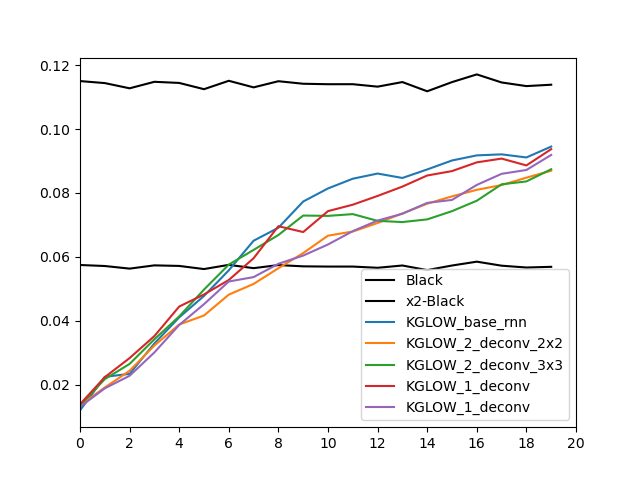

In [24]:
plt.show()